# Advanced Least Square Fitting

If you are trying to find the parameters of a function so that this function describes a particular set of data, you probably want to do a "Least Square Fit" (chisquared-fit) to the data. Least Square Fits are part of the general procedures of minimization. Though not the only way to fit a function to data, it is probably the most common.

There are two ways in Python to access the Least Squares Fitting code: Specifically, [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) or a more generally [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

If you simply want to fit a straight line, or a quadratic, to some data, the `scipy.curve_fit()` will usually give you a reasonable result on the first try. When you try this on a more complex dataset, you often need to do some tricks.

In this notebook you will be guided through fitting a specrum from a NAI detector and a CO-60 source. Note that this is not actual data, but mocked up data, and actual data will probably look different. 

### Setup the environment.

We load the needed packages and then we load the data we want to fit. An easy way to load a text file that has simple columns of numbers is to use `numpy.loadtxt("filename.txt")`. In this case, the data is a single column of numbers.


In [1]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy.integrate as integrate

file_name="NAI_data.txt"
hist_data = np.loadtxt(file_name)


It is never safe to assume that this would have loaded our data correctly, so we need to check that it looks correct. We also need to get the estimated error for each channel. With data like this, where each channel holds a number of _counts_, the error on those counts is estimated as the square root of the counts:

$$
\sigma_N = \sqrt{N}
$$

Text(0,0.5,'count')

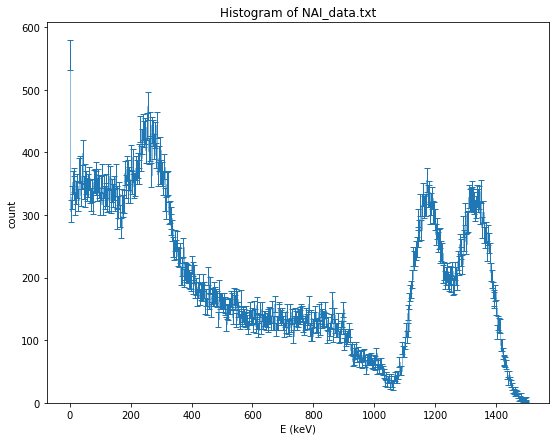

In [2]:
# We also need to have an "x" array, which would be the bin centers. The actual values would depend on the
# experimental setup, where you calibrated the channel number to find the energy of the signal in that channel.
bin_centers = np.linspace(0.5,1500.,len(hist_data)) # The first two numbers depend on the energy scale!! (keV)
hist_errors = np.sqrt(hist_data)                    # Compute the error as square root of number of counts.
hist_errors = hist_errors + (hist_errors <= 0)*1.   # Add 1. if error is zero, since there is uncertainty in zero counts.
# Now plot the data.
fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.errorbar(bin_centers,hist_data,yerr=hist_errors,label="Norm. random distribution",
            drawstyle="steps-mid",linestyle='-',linewidth=0.5,elinewidth=1.,capsize=3,marker="")  
# histtype='step', align='mid' draws a step graph instead of bars, where the data point is at the center of the step.
ax.set_ylim(0) # Otherwise the y-axis will not start at zero.
ax.set_title("Histogram of {}".format(file_name))
ax.set_xlabel('E (keV)')
ax.set_ylabel('count')

You see the spectrum here that was taken in the lab. It has a distinct double peak in the higher channels, and edge (called the Compton edge) around 850, and a smaller one around 1000. There is also a broad background with an additional peak around 250. These numbers are just estimates.

## The initial attempt to fit this.

We now need some function that describes the data. Since we are most interested in the location of the two main peaks, we start with a double gaussian, which would describe each of the peaks, and a polynomial background (quadratic).

In [3]:
# The function for a single Gaussian peak. A is the amplitude, m the mean and s the sigma (width).
def gaussian(x,A,m,s):
    return(A*np.exp( -(x-m)*(x-m)/(2*s*s)))

# This then is the double Gaussian, with a background. We use this as our fit-function.
def combined_g(x,A1,m1,s1,A2,m2,s2,bck1,bck2,bck3):
    return bck1+x*bck2+x*x*bck3+gaussian(x,A1,m1,s1)+gaussian(x,A2,m2,s2)

# To keep easy track of the parameters, I put them in a list, so I can label them easily later.
param_dict=['A1','m1','s1','A2','m2','s2','bck1','bck2','bck3']

We now set the curve fitting code loose on the data with our double Gaussian. We also give it an increased "maxfev" which (read the documentation) tells the fitter how long it should try to make the fit.

The curve fitting function will return two Numpy arrays. The first is the estimated parameters to the function. The second is the _covariant error matrix_, which is a matrix of:$ \sigma_{i,j}$, where $i$ and $j$ are the indexes to the parameters. The diagonal of this matrix then forms the uncertainty on each parameter, and the _off diagonal_ form the correlation between parameters. These _off diagonal_ elements need to be small for a good fit. They will only be small if the parameters of our fit-function are indepenent. 

You can look at the error matrix directly, but it is easier to see what happened when you write a few lines of code to print it nicer.

In [4]:
popt,pcov = optimize.curve_fit(combined_g,bin_centers,hist_data,sigma=hist_errors,maxfev=100000)
print("{:>11s}".format(""),end="")
for i in range(len(popt)):
    print("{:>11s}".format(param_dict[i]),end="")
print("")
for i in range(len(popt)):
    print("{:>11s}".format(param_dict[i]),end="")
    for j in range(len(popt)):
        print("{:11.2e}".format(pcov[i,j]),end="")
    print("")

                    A1         m1         s1         A2         m2         s2       bck1       bck2       bck3
         A1   7.75e+15   2.04e+16   3.10e+16   9.09e+16  -3.28e+15  -5.71e+17  -9.86e+16   2.72e+07  -1.65e+02
         m1  -4.99e+16   7.47e+17  -2.59e+19  -1.45e+18   2.71e+16   9.41e+18   1.50e+18  -6.85e+06   4.68e+03
         s1  -1.00e+18  -2.83e+19   5.38e+20  -2.44e+19   7.71e+17   1.33e+20   2.54e+19  -1.35e+10   1.03e+05
         A2  -3.00e+16  -9.39e+17  -1.28e+19  -1.83e+18   5.86e+16   1.09e+19   1.86e+18  -4.45e+08   6.90e+03
         m2   4.76e+14   7.20e+15   3.49e+17   5.15e+16   1.57e+16  -5.70e+17  -5.20e+16  -8.67e+07  -3.45e+02
         s2   1.39e+17   6.10e+18   5.92e+19   1.03e+19  -5.93e+17  -1.07e+18  -1.04e+19   1.14e+10  -2.30e+04
       bck1   2.23e+16   9.19e+17   1.27e+19   1.74e+18  -5.54e+16  -1.03e+19  -1.76e+18   4.18e+08  -6.74e+03
       bck2  -5.83e+05   1.67e+08  -9.96e+09  -3.46e+08  -8.81e+07   1.09e+10   3.47e+08   1.51e+00   3.41e-06
 

These numbers are huge, so the errors are huge, and basically our fit completely failed. We can see how badly we did by plotting the data again with an overlay of the function called with the parameters. We also print the parameters, and compute the _Chi-squared goodness of fit_ estimator ($\chi^2$). The $\chi^2$ is computed as:
$$
\chi^2 = \sum_{i=0}^N \frac{\left(y_i - f(x_i)\right)^2}{\sigma_i^2}
$$
where $y_i$ is the data point for bin $i$, and $f(x_i)$ is the function we found for that same bin, and $\sigma_i$ is the error for the data in that bin. 

The $\chi^2$ is a good indicator of how well the fit was performed. It is often easier though to use the reduced $\chi^2$, where you divide the $\chi^2$ by the number of degrees of freedom (NDF). The NDF is the number of data points that you fit minus the number of parameters in your fit function. If you have correct errors on your data, then a reduced-$\chi^2$ of 1 means that your fit statistically goes through all the data points.

Fit results:
Parameters:
A1    -149695.62241 ± 88030743.96991
m1    -2182948.67678 ± 864152628.68620
s1    -47630406.49319 ± 23197749596.83397
A2    1464169.12818 ±      nan
m2    -353896.42656 ± 125323268.37211
s2    -19989152.98351 ±      nan
bck1  -1314040.26509 ±      nan
bck2  -0.37185 ±  1.22700
bck3   0.00010 ±  0.00002
The reduced chi-squared is 44.83726279969939


/Users/maurik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'count')

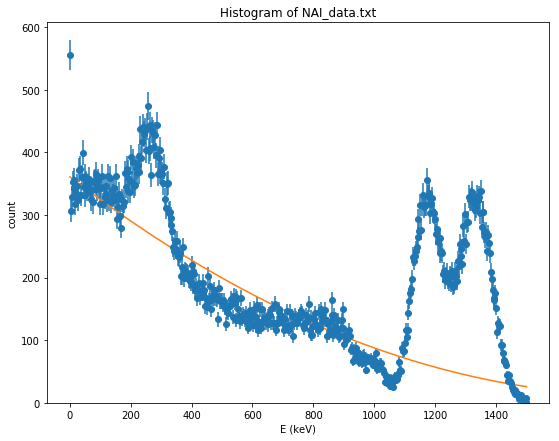

In [5]:
print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))
    
chi_sq = np.sum( ((hist_data - combined_g(bin_centers, *popt))**2)/(hist_errors**2)/(len(hist_data)-len(popt)))
print("The reduced chi-squared is {}".format(chi_sq))
fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.errorbar(bin_centers,hist_data,yerr=hist_errors,fmt='o')
ax.plot(bin_centers,combined_g(bin_centers, *popt))
ax.set_ylim(0) # Otherwise the y-axis will not start at zero.
ax.set_title("Histogram of {}".format(file_name))
ax.set_xlabel('E (keV)')
ax.set_ylabel('count')


So, as predicted, this is a horrible, horrible fit.

## Improving your fit.

The key to improving your fitting results is two procedures:
1. Initially fit only parts of the spectrum.
2. Give the fitting routine good starting values for the parameters.
3. Optionally - sometimes you need to freeze some parameters so the fitter does not change them.

The first step is accomplished by using limits on the data array that are send to the fitter. The second is done by adding an extra argument to the fitter with good starting values. We find these good starting values by guestimation, and by using the results of the reduced x-axis fits. 

### First few fits.

We first take only the first and second peaks and fit single Gaussians to them. Making some trial plots, I find that the first peak goes from about channel 370 to 410, and the second peak from 420 to 480. The code below, with the fitting commented out, helped me find these limits. I then uncomment the fitting call and fit each peak to a single Gaussian.

I still needed to give estimates for the initial values. For $a$ I choose the y value for the highest channel, for $m$ the approximate center, and for $s$ the approximate width. The fit now _converged_, see below.

In [7]:
low_limit=370
hi_limit = 410

popt,pcov = optimize.curve_fit(gaussian,bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],
                               sigma=hist_errors[low_limit:hi_limit],p0=[350.,1180.,50.],maxfev=100000)

print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))
    
chi_sq = np.sum( ((hist_data[low_limit:hi_limit] - gaussian(bin_centers[low_limit:hi_limit], *popt))**2)/(hist_errors[low_limit:hi_limit]**2)/(len(hist_data[low_limit:hi_limit])-len(popt)))
print("The reduced chi-squared is {}".format(chi_sq))

Fit results:
Parameters:
A1    329.78291 ±  4.15986
m1    1177.13536 ±  0.79822
s1    51.41903 ±  1.22695
The reduced chi-squared is 0.8669867695989916


Text(0,0.5,'count')

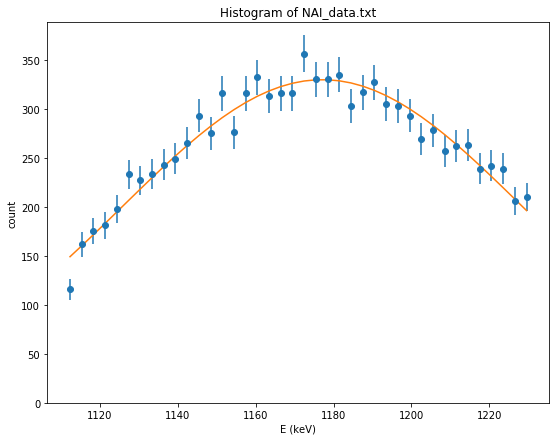

In [8]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.errorbar(bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],yerr=hist_errors[low_limit:hi_limit],fmt='o')
ax.plot(bin_centers[low_limit:hi_limit],gaussian(bin_centers[low_limit:hi_limit], *popt))
ax.set_ylim(0) # Otherwise the y-axis will not start at zero.
ax.set_title("Histogram of {}".format(file_name))
ax.set_xlabel('E (keV)')
ax.set_ylabel('count')

So the first peak finds A=329, m=1177 and s=51, with $\chi^2$=0.87. That is a $\chi^2$ that is less than 1, which sometimes indicates the errors are larger than statistical fluctuations. In this case, it is close enough to 1 to be fine.

For peak2, the same procedure found A = 329, m = 1328, s= 56.5 with $\chi^2$=1.2

We can now fit _both_ Gaussian peaks to the double gaussian function, using the starting parameters we found.

Fit results:
Parameters:
A1    366.99004 ± 10.01694
m1    1172.37839 ±  0.87697
s1    45.89061 ±  0.93244
A2    390.23535 ± 13.55995
m2    1330.03079 ±  0.89080
s2    62.24084 ±  1.46297
bck1  2633.20357 ± 428.17089
bck2  -4.18170 ±  0.69734
bck3   0.00162 ±  0.00027
The reduced chi-squared is 0.9490224616860591


Text(0,0.5,'count')

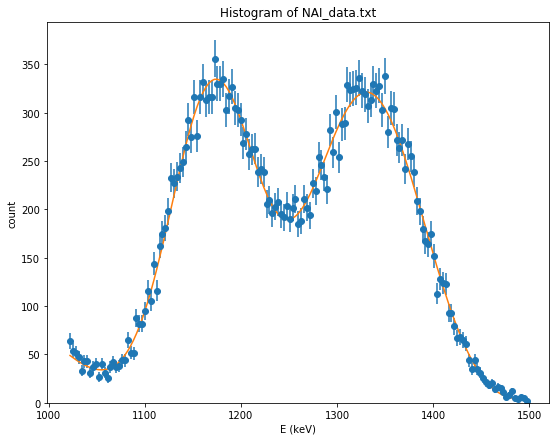

In [9]:
low_limit= 340
hi_limit = 499

popt,pcov = optimize.curve_fit(combined_g,bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],
                               sigma=hist_errors[low_limit:hi_limit],p0=[329.,1177.,51.,329,1328.,56.5,0.,0.,0.],maxfev=100000)
# popt=[329.,1177.,51.,329.,1328.,56.5,0.,0.,0.]
print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))
    
chi_sq = np.sum( ((hist_data[low_limit:hi_limit] - combined_g(bin_centers[low_limit:hi_limit], *popt))**2)/(hist_errors[low_limit:hi_limit]**2)/(len(hist_data[low_limit:hi_limit])-len(popt)))
print("The reduced chi-squared is {}".format(chi_sq))

fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.errorbar(bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],yerr=hist_errors[low_limit:hi_limit],fmt='o')
ax.plot(bin_centers[low_limit:hi_limit],combined_g(bin_centers[low_limit:hi_limit], *popt))
ax.set_ylim(0) # Otherwise the y-axis will not start at zero.
ax.set_title("Histogram of {}".format(file_name))
ax.set_xlabel('E (keV)')
ax.set_ylabel('count')

We now have a reasonable fit of the two Gaussian peaks. If that is all we wanted, we can be done.

If we wanted to also fit the lower part of this spectrum, then our current fit function is clearly not going to be sufficient. We would need something to describe the Compton edges. If you look this up you can find papers on the correct description of this shape (e.g. see: [Differentiation method for localization of Compton edge in organic scintillation detectors](https://arxiv.org/pdf/1610.09185.pdf) ]

The Compton edge can be described with:
$$
\begin{array}{lcl}
R(E) &=& \alpha \ \mathrm{erfc}\left(\frac{E - E_c}{\sqrt{2}\sigma} \right)+\beta e^{ \frac{-(E-E_c)^2}{2\sigma^2}} \\
\alpha  &=& \frac{1}{2} \left( a(E^2+\sigma^2) + bE + c \right) \\
\beta   &=& \frac{-\sigma}{2\pi} a(E+E_c) + b
\end{array}
$$

where E is the energy (our $x$), $E_c$ is the compton edge, $\sigma$ is the resolution (should be close to the same as that for the peaks) and $a$,$b$,$c$ are just parameters for the fit.

In [40]:
from scipy.special import erfc

def compton_edge(x,Ec,s,a,b,c):
    alpha = 0.5*(a*(x*x + s*s) + b*x + c)
    beta  = (-s/(2*np.pi))*a*(x + Ec) + b
    compt = alpha*erfc( (x-Ec)/(np.sqrt(2)*s)) + beta*np.exp( (-(x-Ec)**2)/(2*s*s))
    return(compt)

# This then is the double Gaussian, with 2 compton edges, and with a background. We use this as our fit-function.
def combined_g2(x,A1,m1,s1,A2,m2,s2,bck1,bck2,bck3,Ec1,S1,a1,b1,c1,Ec2,S2,a2,b2,c2):
    out  = bck1+x*bck2+x*x*bck3
    out += gaussian(x,A1,m1,s1)+compton_edge(x,Ec1,S1,a1,b1,c1)
    out += gaussian(x,A2,m2,s2)+compton_edge(x,Ec2,S2,a2,b2,c2)
    return(out)

param_dict=['A1','m1','s1','A2','m2','s2','bck1','bck2','bck3','Ec1','S1','a1','b1','c1','Ec2','S2','a2','b2','c2']
    

Fit results:
Parameters:
A1    463.33160 ± 224.90900
m1    1164.78453 ± 10.30959
s1    58.35302 ± 11.24135
A2    358.21887 ± 48.58845
m2    1332.11738 ±  2.26521
s2    54.14178 ±  2.44191
bck1  -2733.78529 ± 4414.25458
bck2   3.62212 ±  5.88258
bck3  -0.00120 ±  0.00196
Ec1   958.61402 ±  6.07884
S1    36.15169 ±  5.53861
a1     0.00723 ±  0.00251
b1    -12.07194 ±  3.57289
c1    4862.44756 ± 1094.27775
Ec2   1089.60469 ± 50.11576
S2    21.59266 ± 18.70925
a2    -0.00588 ±  0.00134
b2     8.19711 ±  3.61383
c2    -1899.90990 ± 3688.74833
The reduced chi-squared is 0.9850751312728545


Text(0,0.5,'count')

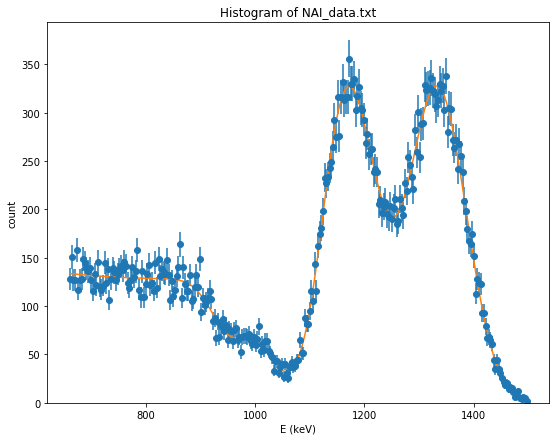

In [85]:
low_limit= 220
hi_limit = 499

# We copy the parameters for the peak, set the background to zero, and make a guess for the compton edges.
start_vals= np.append(popt[0:6],[0.,0.,0.] + [900.,20.,0.,0.,50.] + [1000.,20.,0.,0.,50.])

popt,pcov = optimize.curve_fit(combined_g2,bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],
                               sigma=hist_errors[low_limit:hi_limit],p0=start_vals,maxfev=100000)
#
# If you comment out the optimize.curve_fit, and uncomment the two lines below, you can test your initial values.
#popt= start_vals
#pcov= np.zeros((len(popt),len(popt)))
print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))
    
chi_sq = np.sum( ((hist_data[low_limit:hi_limit] - combined_g2(bin_centers[low_limit:hi_limit], *popt))**2)/(hist_errors[low_limit:hi_limit]**2)/(len(hist_data[low_limit:hi_limit])-len(popt)))
print("The reduced chi-squared is {}".format(chi_sq))

fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.errorbar(bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],yerr=hist_errors[low_limit:hi_limit],fmt='o')
ax.plot(bin_centers[low_limit:hi_limit],combined_g2(bin_centers[low_limit:hi_limit], *popt))
ax.set_ylim(0) # Otherwise the y-axis will not start at zero.
ax.set_title("Histogram of {}".format(file_name))
ax.set_xlabel('E (keV)')
ax.set_ylabel('count')

So now we have the fit up to the compton edges, down to the energy of about 600 keV. If you try to go down further in a big step, say to low_limit=120, the fit will fail. 

Instead of jumping down in one big step, we can go small steps. Lower low_limit a bit, then take the output parameters, and use those as start_vals, then lower low_limit, until you get to a point where the fit keeps failing.

### Try it:

In [86]:
popt

array([ 4.63331600e+02,  1.16478453e+03,  5.83530207e+01,  3.58218873e+02,
        1.33211738e+03,  5.41417786e+01, -2.73378529e+03,  3.62211542e+00,
       -1.19992335e-03,  9.58614016e+02,  3.61516875e+01,  7.22978618e-03,
       -1.20719449e+01,  4.86244756e+03,  1.08960469e+03,  2.15926618e+01,
       -5.88056114e-03,  8.19710877e+00, -1.89990990e+03])

Fit results:
Parameters:
A1    464.48043 ± 228.86697
m1    1164.76661 ± 10.51859
s1    58.37960 ± 11.47298
A2    359.01573 ± 49.18640
m2    1332.10245 ±  2.26132
s2    54.22555 ±  2.43305
bck1  -2719.74597 ± 4500.47275
bck2   3.59599 ±  5.99884
bck3  -0.00119 ±  0.00200
Ec1   959.29968 ±  5.76544
S1    35.71954 ±  5.13601
a1     0.00716 ±  0.00238
b1    -11.96365 ±  3.35812
c1    4823.11428 ± 1009.99462
Ec2   1089.08781 ± 50.17760
S2    21.85439 ± 17.83673
a2    -0.00594 ±  0.00126
b2     8.30112 ±  3.78668
c2    -1945.67332 ± 3831.46522
The reduced chi-squared is 0.9745253765016432


Text(0,0.5,'count')

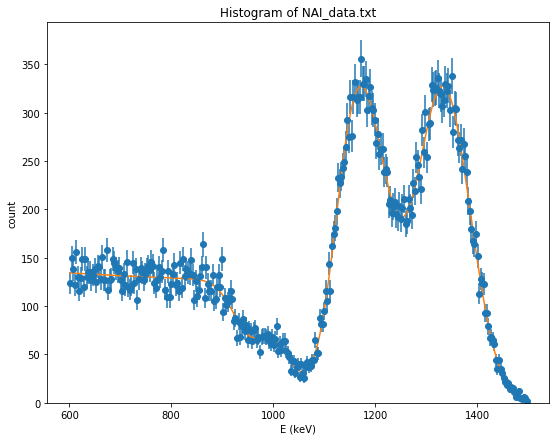

In [87]:
low_limit= 200
hi_limit = 499

# We copy the parameters for the peak, set the background to zero, and make a guess for the compton edges.
start_vals= np.append(popt[0:6],[0.,0.,0.] + [900.,20.,0.,0.,50.] + [1000.,20.,0.,0.,50.])
start_vals = np.array([ 4.88899797e+02,  1.16386614e+03,  5.92727420e+01,  3.64151008e+02,
        1.33182522e+03,  5.44118239e+01, -3.21187042e+03,  4.25283923e+00,
       -1.40798195e-03,  9.58953683e+02,  3.61350833e+01,  7.53460258e-03,
       -1.24986260e+01,  4.98325177e+03,  1.09291562e+03,  2.32709739e+01,
       -5.98122480e-03,  7.99885706e+00, -1.54465647e+03])
popt,pcov = optimize.curve_fit(combined_g2,bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],
                               sigma=hist_errors[low_limit:hi_limit],p0=start_vals,maxfev=100000)
#
# If you comment out the optimize.curve_fit, and uncomment the two lines below, you can test your initial values.
#popt= start_vals
#pcov= np.zeros((len(popt),len(popt)))
print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))
    
chi_sq = np.sum( ((hist_data[low_limit:hi_limit] - combined_g2(bin_centers[low_limit:hi_limit], *popt))**2)/(hist_errors[low_limit:hi_limit]**2)/(len(hist_data[low_limit:hi_limit])-len(popt)))
print("The reduced chi-squared is {}".format(chi_sq))

fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.errorbar(bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],yerr=hist_errors[low_limit:hi_limit],fmt='o')
ax.plot(bin_centers[low_limit:hi_limit],combined_g2(bin_centers[low_limit:hi_limit], *popt))
ax.set_ylim(0) # Otherwise the y-axis will not start at zero.
ax.set_title("Histogram of {}".format(file_name))
ax.set_xlabel('E (keV)')
ax.set_ylabel('count')

Now, assuming you have a good fit down to channel 120 or so, we can only go further down by adding the peak at the low part of the spectrum, with an energy of about 220 keV. We add this Gaussian to our fit function, and then try again.



In [82]:
# Extend the fit function with an additional Gaussian.
# This then is the double Gaussian, with 2 compton edges, and with a background. We use this as our fit-function.
def combined_g3(x,A1,m1,s1,A2,m2,s2,bck1,bck2,bck3,Ec1,S1,a1,b1,c1,Ec2,S2,a2,b2,c2,A3,m3,s3):
    out  = bck1+x*bck2+x*x*bck3
    out += gaussian(x,A1,m1,s1)+compton_edge(x,Ec1,S1,a1,b1,c1)
    out += gaussian(x,A2,m2,s2)+compton_edge(x,Ec2,S2,a2,b2,c2)
    out += gaussian(x,A3,m3,s3)
    return(out)

param_dict=['A1','m1','s1','A2','m2','s2','bck1','bck2','bck3',
            'Ec1','S1','a1','b1','c1','Ec2','S2','a2','b2','c2',
            'A3','m3','s3']

 

Fit results:
Parameters:
A1    394.23551 ± 62.02829
m1    1168.25895 ±  3.44358
s1    54.54706 ±  4.12498
A2    344.24830 ± 19.91303
m2    1332.63713 ±  1.36583
s2    53.80547 ±  1.93981
bck1  -1319.79401 ± 1157.15939
bck2   1.73210 ±  1.56805
bck3  -0.00057 ±  0.00053
Ec1   966.52722 ± 29.50474
S1    42.72844 ± 10.72800
a1     0.00903 ±  0.00942
b1    -14.92332 ± 14.29958
c1    5858.89210 ± 4613.21218
Ec2   1075.39494 ± 10.81041
S2    18.68544 ± 11.01605
a2    -0.00803 ±  0.00909
b2    12.52742 ± 13.36015
c2    -4171.04419 ± 3986.72387
A3    184.28132 ±  4.81710
m3    263.12442 ±  1.50542
s3    54.25611 ±  1.61631
The reduced chi-squared is 1.1706565386166325


Text(0,0.5,'count')

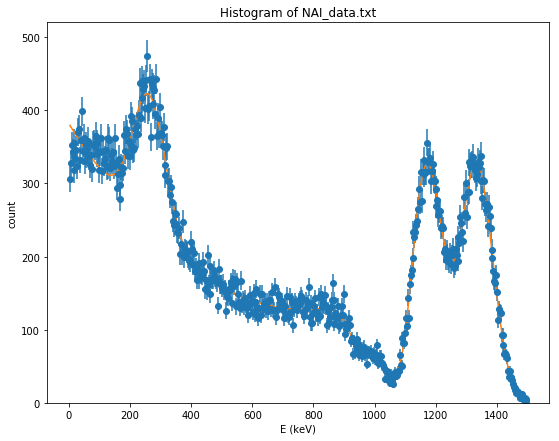

In [89]:
low_limit= 1
hi_limit = 499

last_popt=np.array([ 4.63331600e+02,  1.16478453e+03,  5.83530207e+01,  3.58218873e+02,
        1.33211738e+03,  5.41417786e+01, -2.73378529e+03,  3.62211542e+00,
       -1.19992335e-03,  9.58614016e+02,  3.61516875e+01,  7.22978618e-03,
       -1.20719449e+01,  4.86244756e+03,  1.08960469e+03,  2.15926618e+01,
       -5.88056114e-03,  8.19710877e+00, -1.89990990e+03])

# We copy the parameters for the peak, set the background to zero, and make a guess for the compton edges.
start_vals= np.append(last_popt,[100.,220.,30.]) # Extend the last set with a guess for the third peak.

popt,pcov = optimize.curve_fit(combined_g3,bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],
                               sigma=hist_errors[low_limit:hi_limit],p0=start_vals,maxfev=100000)
#
# If you comment out the optimize.curve_fit, and uncomment the two lines below, you can test your initial values.
#popt= start_vals
#pcov= np.zeros((len(popt),len(popt)))
print("Fit results:")
print("Parameters:")
for i,(p,pe) in enumerate(zip(popt,np.sqrt(np.diag(pcov)))):
    print("{:4s}  {:8.5f} ± {:8.5f}".format(param_dict[i],p,pe))
    
chi_sq = np.sum( ((hist_data[low_limit:hi_limit] - combined_g3(bin_centers[low_limit:hi_limit], *popt))**2)/(hist_errors[low_limit:hi_limit]**2)/(len(hist_data[low_limit:hi_limit])-len(popt)))
print("The reduced chi-squared is {}".format(chi_sq))

fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.errorbar(bin_centers[low_limit:hi_limit],hist_data[low_limit:hi_limit],yerr=hist_errors[low_limit:hi_limit],fmt='o')
ax.plot(bin_centers[low_limit:hi_limit],combined_g3(bin_centers[low_limit:hi_limit], *popt))
ax.set_ylim(0) # Otherwise the y-axis will not start at zero.
ax.set_title("Histogram of {}".format(file_name))
ax.set_xlabel('E (keV)')
ax.set_ylabel('count')

And there you have a 22 parameter fit, that describes the data remarkably well.

##### A final note on the uncertainties:

You can see from your fit results that a number of paramters are not so well determined, and end up being consistent with zero. For example, bck3 is very small, and the error makes it nearly consistent with zero. The parameters, a1, b1 and a2, b2, are also poorly defined. You may thus get a _better_ result if you force these parameters to be zero. In other words, remove them from your fit. 
